# Filtering a density field with ``nbodykit``

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

import nbodykit.lab as nbk

## Definitions for cosmology and sims

In [3]:
# Define box size (in h/Mpc) and fundamental mode
Lbox = 1000
kf = 2*np.pi/Lbox
print('k_f for Lbox = ' + str(Lbox) + ' is ' + str(kf))

k_f for Lbox = 1000 is 0.00628318530718


In [4]:
# Define a LCDM linear power spectrum
redshift = 0
cosmo = nbk.cosmology.Planck15
Plin = nbk.cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')

In [5]:
# Set up parameters for Gaussian realization(s). 
# kmin and dk are values we'll use for power spectrum binning.
seed0 = 1
Nmesh = 128
kmin = kf*0.5
dk = kf

## Filtering density field with isotropic filter

In [6]:
# Example filter: Gaussian in k, for simplicity
def W(k,k0):
    return np.exp(-k**2./k0**2.)

In [10]:
# Routine that takes a mesh and returns a filtered copy.
# For discussion, see the nbodykit documentation at
#    https://nbodykit.readthedocs.io/en/latest/mesh/common-operations.html?highlight=apply .
# An anisotropic filter would take more work to implement
def filter_mesh(mesh,k0):
    # Function to feed to "mesh.apply"
    def filter(k,v):
        # Compute |\vec{k}| values on the mesh                                                                                                          
        kk = sum(ki ** 2. for ki in k)**0.5
        # Compute W(|\vec{k}|) values on the mesh
        W_mesh = W(kk,k0)
        # Multiply original mesh values by filter
        return v * W_mesh
    
    # Make local copy of mesh with filter applied
    mesh_copy = mesh.apply(filter,mode='complex',kind='wavenumber')
    
    return mesh_copy

In [14]:
# Generating Gaussian realization and measuring power spectrum
lcdm_mesh = nbk.LinearMesh(Plin, Nmesh=Nmesh, BoxSize=Lbox, seed=seed0)
lcdm_r = nbk.FFTPower(lcdm_mesh, mode='1d', dk=dk, kmin=kmin)
Pk_lcdm = lcdm_r.power

In [29]:
# Filtering realization and measuring power spectrum
lcdm_filt_mesh = filter_mesh(lcdm_mesh,0.3)
lcdm_filt_r = nbk.FFTPower(lcdm_filt_mesh, mode='1d', dk=dk, kmin=kmin)
Pk_lcdm_filt = lcdm_filt_r.power

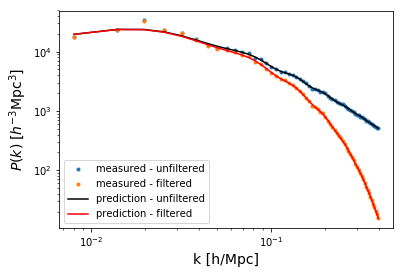

In [48]:
# Plotting measured power spectra
plt.loglog(Pk_lcdm['k'],Pk_lcdm['power'],'.',label='measured - unfiltered')
plt.loglog(Pk_lcdm_filt['k'],Pk_lcdm_filt['power'],'.',label='measured - filtered')

plt.loglog(Pk_lcdm['k'],Plin(Pk_lcdm['k']),'-',color='black',label='prediction - unfiltered')
plt.loglog(Pk_lcdm['k'],Plin(Pk_lcdm['k'])*W(Pk_lcdm['k'],0.3)**2,'-',color='red',
          label='prediction - filtered')

plt.xlabel('k [h/Mpc]',size=14);
plt.ylabel(r'$P(k)\; [h^{-3} {\rm Mpc}^3]$',size=14);
plt.legend();